# **RUN BATCH EXPERIMENTS**

Este notebook ejecuta y documenta todos los experimentos del proyecto de generación y evaluación de conversaciones sintéticas con LLMs y con distintas técnicas de prompt engineering. Cada bloque experimental está automatizado y organizado cronológicamente para facilitar la trazabilidad, reproducibilidad y análisis posterior de los resultados.

**Mount Google Drive (data is stored here)**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)






Mounted at /content/drive


Navigate to the folder

In [3]:
%cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


**API KEY**

In [4]:
!pip install python-dotenv




In [5]:
from dotenv import load_dotenv
import os

#  Load key from .env
load_dotenv("/content/drive/My Drive/TFG_prompting/keys.env")

# Mostrar si la clave se cargó bien
api_key = os.getenv("GROQ_API_KEY")
print("¿Clave cargada correctamente?:", bool(api_key))
print("Tu clave (primeros 5 caracteres):", api_key[:5] if api_key else "Ninguna")

¿Clave cargada correctamente?: True
Tu clave (primeros 5 caracteres): gsk_2


# **EXPERIMENTO 1: Validación inicial del pipeline**

Los resultados del Experimento 1 (validación inicial del pipeline) se almacenan en la carpeta /experiments/llama3_8b/validation/ y experiments/llama3_70b/validation/

Para acceder a las calses no situamos en la carpeta que contiene las clases dialog_generator.py y dialog_evaluator.py

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/TFG_prompting")



Lo tenemos que lanzar dos veces, una para 70b y otra para 80b, es decir 100 diálogos se generan para el modelo llama-8b y otros 100 para llama-70b para comprobar que el sistema funciona correctamente

In [ ]:
import time
import json
import re
from dialog_generator import DialogGenerator
from dialog_evaluator import DialogEvaluator
from pathlib import Path

# === CONFIGURACIÓN ===
BASE_DIR = Path("/content/drive/MyDrive/TFG_prompting/experiments/llama3_8b/validation") # modificamos la carpeta donde guardar los resultados dependiendo del modelo que ejecutemos
REAL_DIR = Path("/content/drive/MyDrive/TFG_prompting/data/real_dialogs")
SPEC_DIR = BASE_DIR / "specifications"
GEN_DIR = BASE_DIR / "generated_dialogs"
EVAL_DIR = BASE_DIR / "evaluated_dialogs"
PROMPTS_DIR = Path("/content/drive/MyDrive/TFG_prompting/prompts")

BACKEND = "groq"
MODEL_NAME = "llama3-8b-8192" #modificamos según el modelo que queramos ejecutar "llama3-8b-8192" //"llama3-70b-8192"

# Crear carpetas si no existen
for folder in [SPEC_DIR, GEN_DIR, EVAL_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# Inicializar generador y evaluador
generator = DialogGenerator(model_name=MODEL_NAME, backend=BACKEND)
evaluator = DialogEvaluator(model_name=MODEL_NAME, backend=BACKEND)

# Cargar los 100 diálogos
real_dialogs = sorted(REAL_DIR.glob("dialog_*.txt"))

# Procesar en lote
for dialog_path in real_dialogs:
    dialog_id = dialog_path.stem
    print(f"\n🔁 Processing: {dialog_id}")

    try:
        real_dialog = dialog_path.read_text()

        # 1. Generar especificación
        spec = generator.generate_specification(
            real_dialog,
            prompt_path=str(PROMPTS_DIR / "prompt_generate_specification.txt")
        )
        (SPEC_DIR / f"{dialog_id}_spec.json").write_text(json.dumps(spec, indent=2))

        # 2. Generar diálogo sintético
        generated = generator.generate_dialog(
            spec,
            prompt_path=str(PROMPTS_DIR / "prompt_generate_dialog.txt")
        )
        (GEN_DIR / f"{dialog_id}_gen.txt").write_text(generated)

        # 3. Evaluar diálogo
        print("⏳ Evaluating...")
        scores = evaluator.evaluate(
            generated_dialog=generated,
            reference_dialog=real_dialog,
            specification=spec,
            prompt_path=str(PROMPTS_DIR / "prompt_evaluate.txt")
        )
        if "comments" not in scores:
            scores["comments"] = "No comment provided."

        (EVAL_DIR / f"{dialog_id}_eval.json").write_text(json.dumps(scores, indent=2))
        print(f"✅ Finished {dialog_id}")

    except Exception as e:
        print(f"❌ Failed to process {dialog_id}: {e}")

print("🎉 All refined dialogs processed!")



🔁 Processing: dialog_001
🟡 Model output for specification:
 {
  "topic": "meeting with a client",
  "turns": 6,
  "participants": 2,
  "tone": {
    "P1": "concerned",
    "P2": "relaxed"
  },
  "goals": {
    "P1": "remind participant of a meeting",
    "P2": "get reminder about a meeting"
  },
  "subplots": ["forgetfulness"],
  "imperfections": ["hesitation", "repetition"]
⏳ Evaluating...
🟡 Model output for evaluation:
 {
  "fluency": 4,
  "coherence": 5,
  "realism": 4,
  "fidelity_to_specification": 5,
  "engagement": 3,
  "originality": 5,
  "comments": "The dialog is fluent and coherent, but the responses are somewhat generic and lack emotional depth."
}
✅ Finished dialog_001

🔁 Processing: dialog_002
🟡 Model output for specification:
 {
  "topic": "booking tickets and hotel",
  "turns": 6,
  "participants": 2,
  "tone": {
    "P1": "frustrated",
    "P2": "apologetic"
  },
  "goals": {
    "P1": "ensure tickets and hotel are booked",
    "P2": "avoid responsibility for not book

Para guardar los resultados en un excel utilizamos este código:

In [ ]:

import pandas as pd
import json
from pathlib import Path


# === Paths ===
BASE_DIR = Path("/content/drive/MyDrive/TFG_prompting/experiments/llama3_70b/validation") # modificamos llama3_8b a llama3_70b para guardar el excel de los diálogos generados con el modelo 70b
REAL_PATH = Path("/content/drive/MyDrive/TFG_prompting/data/real_dialogs")
SPEC_PATH = BASE_DIR / "specifications"
GEN_PATH = BASE_DIR / "generated_dialogs"
EVAL_PATH = BASE_DIR / "evaluated_dialogs"

# Crear lista de filas
rows = []

for gen_file in sorted(GEN_PATH.glob("dialog_*_gen.txt")):
    dialog_id = gen_file.stem.replace("_gen", "")

    try:
        generated_dialog = gen_file.read_text().strip()

        real_path = REAL_PATH / f"{dialog_id}.txt"
        spec_path = SPEC_PATH / f"{dialog_id}_spec.json"
        eval_path = EVAL_PATH / f"{dialog_id}_eval.json"

        real_dialog = real_path.read_text().strip() if real_path.exists() else ""
        spec = json.loads(spec_path.read_text()) if spec_path.exists() else {}
        auto_eval = json.loads(eval_path.read_text()) if eval_path.exists() else {}

        row = {
            "ID": dialog_id,
            "Generated Dialog": generated_dialog,
            "Real Dialog": real_dialog,
            "Specification": json.dumps(spec, indent=2),
            "Fluency (auto)": auto_eval.get("fluency", None),
            "Coherence (auto)": auto_eval.get("coherence", None),
            "Realism (auto)": auto_eval.get("realism", None),
            "Fidelity (auto)": auto_eval.get("fidelity_to_specification", None),
            "Engagement (auto)": auto_eval.get("engagement", None),
            "Originality (auto)": auto_eval.get("originality", None),
            "Comments (auto)": auto_eval.get("comments", "No comment provided."),
            "Fluency (human)": "",
            "Coherence (human)": "",
            "Realism (human)": "",
            "Fidelity (human)": "",
            "Engagement (human)": "",
            "Originality (human)": "",
            "Comments (human)": ""
        }

        rows.append(row)

    except Exception as e:
        print(f"❌ Error with dialog {dialog_id}: {e}")

# Crear DataFrame y guardar Excel
df = pd.DataFrame(rows)
output_path = "/content/drive/MyDrive/TFG_prompting/results_excel/experiment1/evaluation_template_llama3_70b.xlsx" #modificamos de 8b a 70b
df.to_excel(output_path, index=False)

print(f"✅ Template refined creada con {len(df)} diálogos: {output_path}")


✅ Template refined creada con 100 diálogos: /content/drive/MyDrive/TFG_prompting/results_excel/experiment1/evaluation_template_llama3_70b.xlsx


A partir de los excels, se van a sacar algunas métricas y visualizaciones

In [ ]:
import pandas as pd
import numpy as np

# Cargar Excel generado en el experimento
path_8b = "/content/drive/MyDrive/TFG_prompting/results_excel/experiment1/evaluation_template_llama3_8b.xlsx"
path_70b = "/content/drive/MyDrive/TFG_prompting/results_excel/experiment1/evaluation_template_llama3_70b.xlsx"

df_8b = pd.read_excel(path_8b)
df_70b = pd.read_excel(path_70b)

df_8b["Model"] = "LLaMA 3 8B"
df_70b["Model"] = "LLaMA 3 70B"
df = pd.concat([df_8b, df_70b])

# Seleccionar columnas de métricas automáticas
metrics = [
    "Fluency (auto)",
    "Coherence (auto)",
    "Realism (auto)",
    "Fidelity (auto)",
    "Engagement (auto)",
    "Originality (auto)"
]

# Calcular media y std por modelo
means = df.groupby("Model")[metrics].mean().round(2)
stds = df.groupby("Model")[metrics].std().round(2)
summary_stats = pd.concat([means, stds], keys=["mean", "std"])
display(summary_stats)

# Porcentaje de puntuaciones 5/5
perc_5s = df[metrics + ["Model"]].copy()
for metric in metrics:
    perc_5s[metric] = (perc_5s[metric] == 5).astype(int)
perc_5s = perc_5s.groupby("Model").mean().round(2) * 100
perc_5s.columns = [f"{col} (% 5/5)" for col in perc_5s.columns]
display(perc_5s)

# Número de veces que 70B supera a 8B por métrica
counts = []
for metric in metrics:
    better = (df_70b[metric].values > df_8b[metric].values).sum()
    counts.append((metric, better))
beats_df = pd.DataFrame(counts, columns=["Metric", "70B beats 8B"])
display(beats_df)



Fluency (auto)  Coherence (auto)  Realism (auto)  \
     Model                                                           
mean LLaMA 3 70B            4.39               5.0            4.21   
     LLaMA 3 8B             4.00               5.0            4.00   
std  LLaMA 3 70B            0.49               0.0            0.41   
     LLaMA 3 8B             0.00               0.0            0.00   

                  Fidelity (auto)  Engagement (auto)  Originality (auto)  
     Model                                                                
mean LLaMA 3 70B              5.0               3.59                3.65  
     LLaMA 3 8B               5.0               3.00                5.00  
std  LLaMA 3 70B              0.0               0.59                0.50  
     LLaMA 3 8B               0.0               0.00                0.00

,Fluency (auto) (% 5/5),Coherence (auto) (% 5/5),Realism (auto) (% 5/5),Fidelity (auto) (% 5/5),Engagement (auto) (% 5/5),Originality (auto) (% 5/5)
Model,,,,,,
LLaMA 3 70B,39.0,100.0,21.0,100.0,5.0,0.0
LLaMA 3 8B,0.0,100.0,0.0,100.0,0.0,100.0


,Metric,70B beats 8B
0,Fluency (auto),39
1,Coherence (auto),0
2,Realism (auto),21
3,Fidelity (auto),0
4,Engagement (auto),54
5,Originality (auto),0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Crear subcarpeta plots/experiment1 si no existe
plots_dir = Path("/content/drive/MyDrive/TFG_prompting/plots/experiment1")
plots_dir.mkdir(parents=True, exist_ok=True)

# === 1. Gráfico de barras de medias por métrica y modelo ===
fig1, ax1 = plt.subplots(figsize=(10, 6))
means.T.plot(kind="bar", ax=ax1)
ax1.set_title("Media de puntuaciones automáticas por métrica y modelo")
ax1.set_ylabel("Media")
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(title="Modelo")
plt.tight_layout()
fig1.savefig(plots_dir / "plot_means.png")
plt.close(fig1)

# === 2. Boxplots de cada métrica ===
for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df, x="Model", y=metric, ax=ax)
    ax.set_title(f"Boxplot - {metric}")
    plt.tight_layout()
    fig.savefig(plots_dir / f"boxplot_{metric.replace(' ', '_').replace('(auto)', '').strip().lower()}.png")
    plt.close(fig)

# === 3. Porcentaje de 5/5 ===
fig3, ax3 = plt.subplots(figsize=(10, 6))
perc_5s.T.plot(kind="bar", ax=ax3)
ax3.set_title("Porcentaje de puntuaciones 5/5 por métrica")
ax3.set_ylabel("% de 5/5")
ax3.set_xticklabels([m.replace(" (% 5/5)", "") for m in perc_5s.columns], rotation=45)
ax3.legend(title="Modelo")
plt.tight_layout()
fig3.savefig(plots_dir / "plot_5s.png")
plt.close(fig3)

# === 4. Barras de veces que 70B supera a 8B ===
fig4, ax4 = plt.subplots(figsize=(8, 5))
sns.barplot(data=beats_df, x="Metric", y="70B beats 8B", ax=ax4)
ax4.set_title("Veces que LLaMA 3 70B supera a 8B")
ax4.set_ylabel("Número de diálogos")
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
plt.tight_layout()
fig4.savefig(plots_dir / "plot_better_70b.png")
plt.close(fig4)

print("✅ Gráficos guardados en: plots/experiment1/")



✅ Gráficos guardados en: plots/experiment1/


/tmp/ipython-input-23-643067874.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


# **EXPERIMENTO 2: IMPACTO DEL ESTILO DE PROMPT EN LA CALIDAD DE LOS DIÁLOGOS (Evaluación Humana vs Manual)**

3 variantes de prompts --> Vanilla, Few-shot y No-Imperfections --> vamos modificando carpetas donde guardar los resultados y tipos de prompts dependiendo del variante de prompt, de los 3 de este experimento, que queramos ejecutar


In [ ]:
import time
import json
import re
from dialog_generator import DialogGenerator
from dialog_evaluator import DialogEvaluator
from pathlib import Path

# === CONFIGURACIÓN ===
BASE_DIR = Path("/content/drive/MyDrive/TFG_prompting/experiments/llama3_8b/vanilla_fewshot_noimperf/noimperf") # modificamos la carpeta donde guardar los resultados dependiendo del modelo que ejecutemos--> llama_8b/ llama_70b y también modifcamos la carpeta final por fewshot/noimperf/vanilla, dependiendo de la variante de prompt que usemos
REAL_DIR = Path("/content/drive/MyDrive/TFG_prompting/data/real_dialogs")
SPEC_DIR = BASE_DIR / "specifications"
GEN_DIR = BASE_DIR / "generated_dialogs"
EVAL_DIR = BASE_DIR / "evaluated_dialogs"
PROMPTS_DIR = Path("/content/drive/MyDrive/TFG_prompting/prompts_variants/vanilla_fewshot_noimperf")

BACKEND = "groq"
MODEL_NAME = "llama3-8b-8192" # "llama3-8b-8192" //"llama3-70b-8192"

# Crear carpetas si no existen
for folder in [SPEC_DIR, GEN_DIR, EVAL_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# Inicializar generador y evaluador
generator = DialogGenerator(model_name=MODEL_NAME, backend=BACKEND)
evaluator = DialogEvaluator(model_name=MODEL_NAME, backend=BACKEND)

# Cargar los últimos 10 real dialogs
real_dialogs = sorted(REAL_DIR.glob("dialog_*.txt"))[-20:] #solo los últimos 20 diálogos

# Procesar en lote
for dialog_path in real_dialogs:
    dialog_id = dialog_path.stem
    print(f"\n🔁 Processing: {dialog_id}")

    try:
        real_dialog = dialog_path.read_text()

        # 1. Generar especificación
        spec = generator.generate_specification(
            real_dialog,
            prompt_path=str(PROMPTS_DIR / "prompt_generate_specification_noimperf.txt") #modificamos por el tipo de variante de prompt que queremos ejecutar (prompt_generate_specification.txt para vanilla y fewshot  )
        )
        (SPEC_DIR / f"{dialog_id}_spec.json").write_text(json.dumps(spec, indent=2))

        # 2. Generar diálogo sintético
        generated = generator.generate_dialog(
            spec,
            prompt_path=str(PROMPTS_DIR / "prompt_generate_dialog_noimperf.txt") #prompt_generate_dialog.txt: vanilla ; prompt_generate_dialog_fewshot.txt: fewshot)
        )
        (GEN_DIR / f"{dialog_id}_gen.txt").write_text(generated)

        # 3. Evaluar diálogo
        print("⏳ Evaluating...")
        scores = evaluator.evaluate(
            generated_dialog=generated,
            reference_dialog=real_dialog,
            specification=spec,
            prompt_path=str(PROMPTS_DIR / "prompt_evaluate.txt")
        )
        if "comments" not in scores:
            scores["comments"] = "No comment provided."

        (EVAL_DIR / f"{dialog_id}_eval.json").write_text(json.dumps(scores, indent=2))
        print(f"✅ Finished {dialog_id}")

    except Exception as e:
        print(f"❌ Failed to process {dialog_id}: {e}")

print("🎉 All refined dialogs processed!")


Gneramos los Excels, para posteriormente sacar métricas y viualizaciones y luego completarlos con la parte de evaluación humana



In [ ]:

import pandas as pd
import json
from pathlib import Path

# === Paths ===
BASE_DIR = Path("/content/drive/MyDrive/TFG_prompting/experiments/llama3_8b/vanilla_fewshot_noimperf/noimperf") # modificamos dependiendo del excel que queramos generar, en este estamos generando el de noimperf del modelo 8b
REAL_PATH = Path("/content/drive/MyDrive/TFG_prompting/data/real_dialogs")
SPEC_PATH = BASE_DIR / "specifications"
GEN_PATH = BASE_DIR / "generated_dialogs"
EVAL_PATH = BASE_DIR / "evaluated_dialogs"

# Crear lista de filas
rows = []

for gen_file in sorted(GEN_PATH.glob("dialog_*_gen.txt")):
    dialog_id = gen_file.stem.replace("_gen", "")

    try:
        generated_dialog = gen_file.read_text().strip()

        real_path = REAL_PATH / f"{dialog_id}.txt"
        spec_path = SPEC_PATH / f"{dialog_id}_spec.json"
        eval_path = EVAL_PATH / f"{dialog_id}_eval.json"

        real_dialog = real_path.read_text().strip() if real_path.exists() else ""
        spec = json.loads(spec_path.read_text()) if spec_path.exists() else {}
        auto_eval = json.loads(eval_path.read_text()) if eval_path.exists() else {}

        row = {
            "ID": dialog_id,
            "Generated Dialog": generated_dialog,
            "Real Dialog": real_dialog,
            "Specification": json.dumps(spec, indent=2),
            "Fluency (auto)": auto_eval.get("fluency", None),
            "Coherence (auto)": auto_eval.get("coherence", None),
            "Realism (auto)": auto_eval.get("realism", None),
            "Fidelity (auto)": auto_eval.get("fidelity_to_specification", None),
            "Engagement (auto)": auto_eval.get("engagement", None),
            "Originality (auto)": auto_eval.get("originality", None),
            "Comments (auto)": auto_eval.get("comments", "No comment provided."),
            "Fluency (human)": "",
            "Coherence (human)": "",
            "Realism (human)": "",
            "Fidelity (human)": "",
            "Engagement (human)": "",
            "Originality (human)": "",
            "Comments (human)": ""
        }

        rows.append(row)

    except Exception as e:
        print(f"❌ Error with dialog {dialog_id}: {e}")

# Crear DataFrame y guardar Excel
df = pd.DataFrame(rows)
output_path = "results_excel/experiment2/evaluation_human_template_noimperf_llama3_8b.xlsx"
df.to_excel(output_path, index=False)

print(f"✅ Template refined creada con {len(df)} diálogos: {output_path}")


VISUALIZACIONES DE LOS EXCELS (una vez ya han sido evaluados automática y manualmente)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Estilo gráfico
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

# Ruta base (ajústala si hace falta)
base_path = Path("/content/drive/MyDrive/TFG_prompting/results_excel/experiment2")
plot_dir = Path("/content/drive/MyDrive/TFG_prompting/plots/experiment2")
plot_dir.mkdir(parents=True, exist_ok=True)

# Archivos .xlsx
files = {
    "llama3_8b_vanilla": "evaluation_human_template_vanilla_llama3_8b.xlsx",
    "llama3_8b_fewshot": "evaluation_human_template_fewshot_llama3_8b.xlsx",
    "llama3_8b_noimperf": "evaluation_human_template_noimperf_llama3_8b.xlsx",
    "llama3_70b_vanilla": "evaluation_human_template_vanilla_llama3_70b.xlsx",
    "llama3_70b_fewshot": "evaluation_human_template_fewshot_llama3_70b.xlsx",
    "llama3_70b_noimperf": "evaluation_human_template_noimperf_llama3_70b.xlsx"
}

# Métricas
metrics = ['Fluency', 'Coherence', 'Realism', 'Fidelity', 'Engagement', 'Originality']
auto_cols = [f"{m} (auto)" for m in metrics]
human_cols = [f"{m} (human)" for m in metrics]

summary = []
correlation_results = {}

# Procesar cada Excel
for key, filename in files.items():
    filepath = base_path / filename
    df = pd.read_excel(filepath)

    # Promedios y desviaciones típicas
    means_auto = df[auto_cols].mean()
    stds_auto = df[auto_cols].std()
    means_human = df[human_cols].mean()
    stds_human = df[human_cols].std()

    # Guardar resumen
    for metric in metrics:
        summary.append({
            "Model_Prompt": key,
            "Metric": metric,
            "Auto_Mean": means_auto[f"{metric} (auto)"],
            "Auto_Std": stds_auto[f"{metric} (auto)"],
            "Human_Mean": means_human[f"{metric} (human)"],
            "Human_Std": stds_human[f"{metric} (human)"]
        })

    # Correlaciones
    corr = df[auto_cols + human_cols].corr().loc[auto_cols, human_cols]
    correlation_results[key] = corr

    # Plot 1: Comparativa de medias
    x = range(len(metrics))
    plt.figure(figsize=(10, 5))
    plt.bar([i - 0.2 for i in x], means_auto, width=0.4, label='Auto', color='skyblue')
    plt.bar([i + 0.2 for i in x], means_human, width=0.4, label='Human', color='salmon')
    plt.xticks(x, metrics)
    plt.ylabel("Average Score")
    plt.title(f"{key} - Media por Métrica")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(plot_dir / f"{key}_barplot.png")
    plt.close()

    # Plot 2: Heatmap de correlación
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"{key} - Correlación Auto vs Human")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{key}_correlation.png")
    plt.close()

# Guardar resumen como DataFrame
summary_df = pd.DataFrame(summary)
summary_df.to_csv(plot_dir / "summary_prompt_styles.csv", index=False)


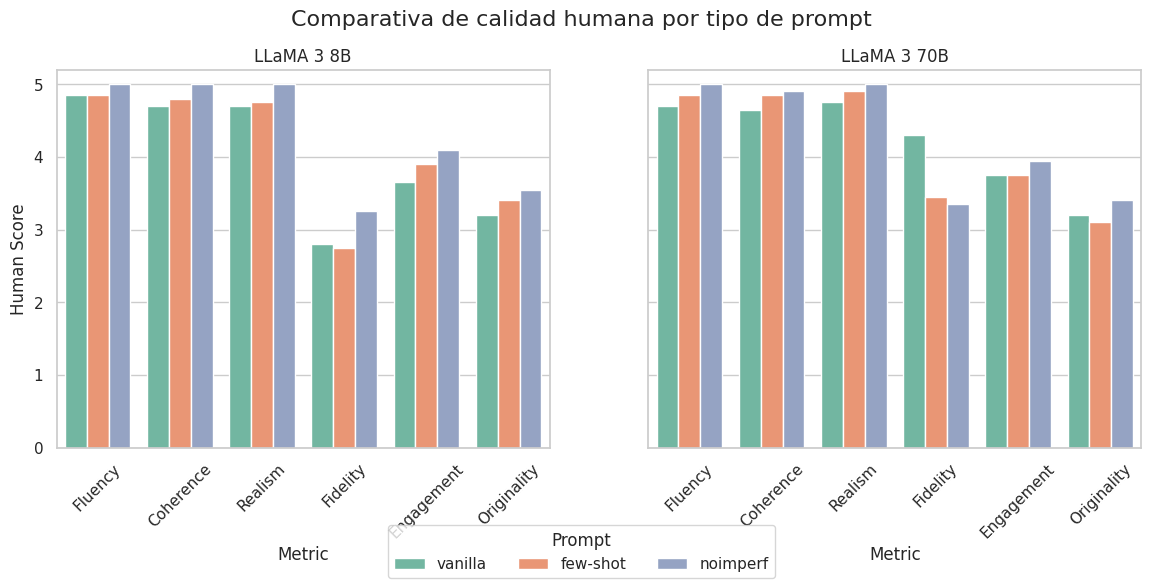

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Rutas
base_path = Path("/content/drive/MyDrive/TFG_prompting/results_excel/experiment2")
plot_dir = Path("/content/drive/MyDrive/TFG_prompting/plots/experiment2")
csv_path = plot_dir / "summary_prompt_styles.csv"

# Cargar resumen
summary_df = pd.read_csv(csv_path)

# Añadir columnas de modelo y tipo de prompt
summary_df["Model"] = summary_df["Model_Prompt"].apply(lambda x: "LLaMA 3 8B" if "8b" in x else "LLaMA 3 70B")
summary_df["Prompt"] = summary_df["Model_Prompt"].apply(
    lambda x: "vanilla" if "vanilla" in x else ("few-shot" if "fewshot" in x else "noimperf")
)

# Métricas
metrics = ['Fluency', 'Coherence', 'Realism', 'Fidelity', 'Engagement', 'Originality']
palette = {"vanilla": "#66c2a5", "few-shot": "#fc8d62", "noimperf": "#8da0cb"}

# Plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, model in enumerate(["LLaMA 3 8B", "LLaMA 3 70B"]):
    df_plot = summary_df[(summary_df["Model"] == model) & (summary_df["Metric"].isin(metrics))]
    sns.barplot(
        data=df_plot,
        x="Metric",
        y="Human_Mean",
        hue="Prompt",
        hue_order=["vanilla", "few-shot", "noimperf"],
        order=metrics,
        palette=palette,
        ax=axes[i]
    )
    axes[i].set_title(model)
    axes[i].set_ylabel("Human Score")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 5.2)
    axes[i].legend_.remove()  # Eliminar leyenda individual

# Título principal y ajustes
fig.suptitle("Comparativa de calidad humana por tipo de prompt", fontsize=16)
fig.subplots_adjust(bottom=0.25, top=0.88)

# Leyenda global centrada debajo
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Prompt",
    loc='lower center',
    bbox_to_anchor=(0.5, 0.02),
    ncol=3
)

# Guardar y mostrar
plt.savefig(plot_dir / "comparison_prompt_styles_by_model.png", bbox_inches='tight')
plt.show()



Diferencia absoluta media entre evaluación automática y humana por métrica

 Diferencia absoluta media por métrica:
Metric
Fidelity       0.941667
Realism        0.833333
Fluency        0.450000
Originality    0.409804
Engagement     0.175000
Coherence      0.141667
Name: Abs_Diff, dtype: float64


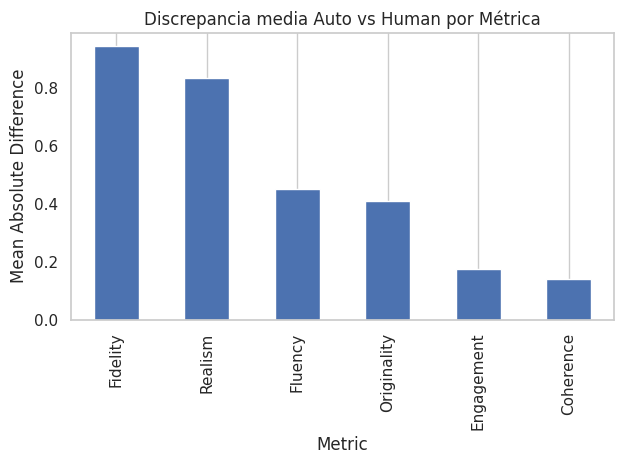

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Cargar el CSV (asegúrate de que este archivo existe en tu Drive)
df = pd.read_csv("/content/drive/MyDrive/TFG_prompting/plots/experiment2/summary_prompt_styles.csv")

# ✅ Calcular la diferencia absoluta entre Auto_Mean y Human_Mean
df['Abs_Diff'] = (df['Auto_Mean'] - df['Human_Mean']).abs()

# ✅ Agrupar por métrica y calcular la media de las diferencias absolutas
mean_abs_diff = df.groupby('Metric')['Abs_Diff'].mean().sort_values(ascending=False)

# ✅ Mostrar el resultado
print(" Diferencia absoluta media por métrica:")
print(mean_abs_diff)

# ✅ Visualización
mean_abs_diff.plot(kind='bar', title='Discrepancia media Auto vs Human por Métrica')
plt.ylabel('Mean Absolute Difference')
plt.xlabel('Metric')
plt.grid(axis='y')
plt.tight_layout()
# Guardar y mostrar
plt.savefig(plot_dir / "discrepancia_media.png", bbox_inches='tight')
plt.show()


# **EXPERIMENTO 3: Comparación de variantes semánticas Tone-Rol-Subplot (Run Batch Generate y Run Batch Evaluate)**

**RUN BATCH GENERATE**

In [ ]:
# !python src/batch_scripts/batch_generate.py


In [ ]:
# !python src/core/repair_failed_specs.py



🔍 Reparando: experiments/llama3_8b/tone/tone_serious/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_8b/tone/tone_humor/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_8b/subplot/with_subplot/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_8b/subplot/without_subplot/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_8b/rol/rol_student_professor/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_8b/rol/rol_friends/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_70b/tone/tone_serious/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_70b/tone/tone_humor/specifications_failed
➡️ Total: 0 | ✅ Éxitos: 0 | ❌ Fallos: 0

🔍 Reparando: experiments/llama3_70b/subplot/with_subplot/s

**RUN BATCH EVALUATE**

GENERATE .xlsx file FOR EVALUATION and evaluated_dialogs/dialog_00x_eval.json

In [ ]:
# !python src/batch_scripts/batch_evaluate.py



**Para lanzar batch_evaluate.py, batch_generate.py y repair_failed_specs.py con un solo comando**

In [ ]:
#!python run_all.py


**Análisis de la evaluación automática con prompt_evaluate_strict.txt**

In [ ]:
from pathlib import Path
import json
import pandas as pd

BASE = Path.cwd() / "experiments"
models = ["llama3_8b", "llama3_70b"]
categories = ["tone", "rol", "subplot"]

all_scores = []

for model_name in models:
    for category in categories:
        category_path = BASE / model_name / category
        if not category_path.exists():
            continue
        for variant_dir in category_path.iterdir():
            evaluated_dir = variant_dir / "evaluated_dialogs"
            if not evaluated_dir.exists():
                continue
            for json_file in evaluated_dir.glob("*.json"):
                try:
                    with open(json_file, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    if isinstance(data, dict):
                        all_scores.append({
                            "model": model_name.replace("llama3_", "llama3-") + "-8192",
                            "category": category,
                            "variant": variant_dir.name,
                            "file": json_file.name,
                            "fluency": data.get("fluency"),
                            "coherence": data.get("coherence"),
                            "realism": data.get("realism"),
                            "fidelity": data.get("fidelity_to_specification"),
                            "engagement": data.get("engagement"),
                            "originality": data.get("originality")
                        })
                except Exception as e:
                    print(f"⚠️ Error reading {json_file}: {e}")

print(f"📊 Total evaluaciones encontradas: {len(all_scores)}")  # Debe ser 180 si están todos

if all_scores:
    df = pd.DataFrame(all_scores)

    print("\n📈 Medias por modelo y categoría:\n")
    print(df.groupby(["model", "category"]).mean(numeric_only=True).round(2))

    print("\n📈 Medias por modelo, categoría y variante:\n")
    print(df.groupby(["model", "category", "variant"]).mean(numeric_only=True).round(2))

    # Guardar si quieres:
    df.to_excel("results_excel/experiment3/automatic_metrics_summary.xlsx", index=False)
else:
    print("❌ No se han encontrado evaluaciones.")


📊 Total evaluaciones encontradas: 180

📈 Medias por modelo y categoría:

                          fluency  coherence  realism  fidelity  engagement  \
model           category                                                      
llama3-70b-8192 rol          4.47       5.00     4.47      5.00        4.07   
                subplot      4.37       5.00     4.30      5.00        3.90   
                tone         4.53       4.97     4.37      4.93        4.07   
llama3-8b-8192  rol          3.67       4.73     3.77      4.57        3.00   
                subplot      3.50       4.67     3.60      4.30        3.17   
                tone         3.50       4.63     3.60      4.47        3.07   

                          originality  
model           category               
llama3-70b-8192 rol              3.68  
                subplot          3.92  
                tone             3.82  
llama3-8b-8192  rol              2.13  
                subplot          2.33  
              

Visualización

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Crear carpeta de salida
os.makedirs("plots/experiment3", exist_ok=True)

# Cargar datos del Excel
df = pd.read_excel("results_excel/experiment3/automatic_metrics_summary.xlsx")

# Renombrar columnas para consistencia
df = df.rename(columns={
    "model": "Model",
    "category": "Category",
    "variant": "Variant",
    "fluency": "Fluency",
    "realism": "Realism",
    "fidelity": "Fidelity",
    "engagement": "Engagement",
    "originality": "Originality"
})

# ----------- PLOTS POR CATEGORÍA -------------

metrics = ["Fluency", "Realism", "Fidelity", "Engagement", "Originality"]
df_cat = df.groupby(["Category", "Model"])[metrics].mean().reset_index()

for metric in metrics:
    plt.figure()
    for model in df_cat["Model"].unique():
        subset = df_cat[df_cat["Model"] == model]
        plt.plot(subset["Category"], subset[metric], marker="o", label=model)

    plt.title(f"{metric} by Category")
    plt.ylabel(metric)
    plt.ylim(0, 6)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/experiment3/{metric.lower()}_by_category.png")
    plt.close()

# ----------- PLOTS POR VARIANTE -------------

metrics_variant = ["Fidelity", "Realism", "Originality"]
df_var = df.groupby(["Variant", "Model"])[metrics_variant].mean().reset_index()

for metric in metrics_variant:
    plt.figure(figsize=(10, 5))
    for model in df_var["Model"].unique():
        subset = df_var[df_var["Model"] == model]
        plt.plot(subset["Variant"], subset[metric], marker="o", label=model)

    plt.title(f"{metric} by Variant")
    plt.ylabel(metric)
    plt.ylim(0, 6)
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/experiment3/{metric.lower()}_by_variant.png")
    plt.close()

print("✅ All plots saved in 'plots/experiment3'")


✅ All plots saved in 'plots/experiment3'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Crear carpeta
os.makedirs("plots/experiment3", exist_ok=True)

# Cargar Excel
df = pd.read_excel("results_excel/experiment3/automatic_metrics_summary.xlsx")

# Renombrar columnas
df = df.rename(columns={
    "model": "Model",
    "category": "Category",
    "variant": "Variant",
    "fluency": "Fluency",
    "realism": "Realism",
    "fidelity": "Fidelity",
    "engagement": "Engagement",
    "originality": "Originality"
})

# ----- PLOT MULTIMÉTRICAS POR CATEGORÍA -----
metrics = ["Fluency", "Realism", "Fidelity", "Engagement", "Originality"]
df_cat = df.groupby(["Category", "Model"])[metrics].mean().reset_index()

categories = df_cat["Category"].unique()
x = np.arange(len(categories))
width = 0.15

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    offset = (i - 2) * width  # para centrar barras
    for model in df_cat["Model"].unique():
        values = df_cat[df_cat["Model"] == model][metric].values
        label = f"{metric} ({model})"
        plt.bar(x + offset, values, width, label=label)

plt.xticks(x, categories)
plt.ylim(0, 6)
plt.ylabel("Average Score")
plt.title("Metrics by Category and Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("plots/experiment3/combined_metrics_by_category.png")
plt.close()

# ----- PLOT MULTIMÉTRICAS POR VARIANTE -----
metrics_variant = ["Fluency", "Realism", "Fidelity", "Engagement", "Originality"]
df_var = df.groupby(["Variant", "Model"])[metrics_variant].mean().reset_index()

variants = df_var["Variant"].unique()
x = np.arange(len(variants))
width = 0.12

plt.figure(figsize=(14, 6))
for i, metric in enumerate(metrics_variant):
    offset = (i - 1) * width  # centrar en torno al eje
    for model in df_var["Model"].unique():
        values = df_var[df_var["Model"] == model][metric].values
        label = f"{metric} ({model})"
        plt.bar(x + offset, values, width, label=label)

plt.xticks(x, variants, rotation=30)
plt.ylim(0, 6)
plt.ylabel("Average Score")
plt.title(" Metrics by Variant and Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("plots/experiment3/combined_metrics_by_variant.png")
plt.close()

print("✅ Plots combinados guardados en 'plots/experiment3'")


✅ Plots combinados guardados en 'plots/experiment3'


**Manual Verification**

In [ ]:
# !python src/manual_verification/verifier_manual_template.py

Análisis y visualizaciones:

In [ ]:
!python src/manual_verification/aggregate_verification.py


✅ Summary saved to verification_summary.xlsx
         Model Category  ... Prompt Type (%)  Overall (%)
0   llama3_70b      rol  ...           100.0         80.0
1   llama3_70b      rol  ...            60.0         60.0
2   llama3_70b  subplot  ...           100.0         60.0
3   llama3_70b  subplot  ...           100.0        100.0
4   llama3_70b     tone  ...            20.0         20.0
5   llama3_70b     tone  ...            80.0         60.0
6    llama3_8b      rol  ...           100.0         80.0
7    llama3_8b      rol  ...            40.0         40.0
8    llama3_8b  subplot  ...           100.0         80.0
9    llama3_8b  subplot  ...           100.0         40.0
10   llama3_8b     tone  ...            40.0         40.0
11   llama3_8b     tone  ...            80.0         60.0

[12 rows x 9 columns]


In [ ]:
!python src/manual_verification/plot_verification_summary.py

✅ Saved plot: plots/plot_topic.png
✅ Saved plot: plots/plot_subplot.png
✅ Saved plot: plots/plot_imperfections.png
✅ Saved plot: plots/plot_prompt_type.png
✅ Saved plot: plots/plot_overall.png


**Plotly verification dashboard**

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# Leer el archivo de resumen
df = pd.read_excel("verification_summary.xlsx")

# Crear etiqueta combinada
df["Label"] = df["Model"] + " | " + df["Variant"]

# Lista de métricas
metrics = ["Topic (%)", "Subplot (%)", "Imperfections (%)", "Prompt Type (%)", "Overall (%)"]

# Crear figura con la métrica por defecto
metric_default = "Overall (%)"
fig = go.Figure()

# Añadir trazas para cada modelo
for model in df["Model"].unique():
    subset = df[df["Model"] == model]
    fig.add_bar(
        x=subset["Label"],
        y=subset[metric_default],
        name=model
    )

# Crear botones para el dropdown
dropdown_buttons = []
for metric in metrics:
    dropdown_buttons.append(
        dict(
            label=metric,
            method="update",
            args=[
                {"y": [df[df["Model"] == model][metric].values for model in df["Model"].unique()]},
                {"yaxis": {"title": metric}}
            ]
        )
    )

# Layout
fig.update_layout(
    title="  Scores by Variant and Model",
    xaxis_title="Variant",
    yaxis_title=metric_default,
    xaxis_tickangle=45,
    height=550,
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        x=1.15,
        y=1.2,
        showactive=True,
    )]
)

fig.show()


# **EXPERIMENTO 4: ABLATION STUDY (v1-v4)**

In [ ]:
%cd /content/drive/MyDrive/TFG_prompting



/content/drive/MyDrive/TFG_prompting


**EXPERIMENT 4.1 --> prompt_evaluate_strict.txt**

In [ ]:
# !python src/batch_scripts/batch_ablation.py

In [ ]:
!python src/export_ablation_results_to_excel.py

**VISUALIZATION WITH PLOTLY**

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
!pip install -q jupyter-dash dash
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00


In [ ]:
from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Leer el Excel
df = pd.read_excel("results_excel/ablation_all_scores_1.xlsx")

app = Dash(__name__)

app.layout = html.Div([
    html.H2("📊 Synthetic Dialogs Ablation Dashboard"),

    html.Label("Model:"),
    dcc.Dropdown(id="model-dropdown", options=[
        {"label": m, "value": m} for m in sorted(df["Model"].unique())
    ], value=sorted(df["Model"].unique())[0]),

    html.Label("Axis:"),
    dcc.Dropdown(id="axis-dropdown"),

    html.Label("Spec Type:"),
    dcc.Dropdown(id="spec-dropdown"),

    html.Label("Prompt Version:"),
    dcc.Dropdown(id="version-dropdown"),

    html.Hr(),
    html.Div(id="scores-output"),
    html.Hr(),
    html.Pre(id="dialog-output", style={
        "whiteSpace": "pre-wrap",
        "backgroundColor": "#f9f9f9",
        "padding": "10px",
        "fontFamily": "monospace",
        "fontSize": "14px",
        "maxHeight": "300px",
        "overflowY": "auto"
    }),

    html.Hr(),
    html.H3(" Mean Scores by Prompt Version"),
    dcc.Graph(id="score-graph"),

    html.H3(" Radar Chart Comparison"),
    dcc.Graph(id="radar-graph"),

    html.H3(" Heatmap of Scores"),
    dcc.Graph(id="heatmap-graph")
])

@app.callback(
    Output("axis-dropdown", "options"),
    Output("axis-dropdown", "value"),
    Input("model-dropdown", "value")
)
def update_axis_options(model):
    options = sorted(df[df["Model"] == model]["Axis"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("spec-dropdown", "options"),
    Output("spec-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value")
)
def update_spec_options(model, axis):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis)]
    options = sorted(filtered["Spec Type"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("version-dropdown", "options"),
    Output("version-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value")
)
def update_version_options(model, axis, spec_type):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis) & (df["Spec Type"] == spec_type)]
    options = sorted(filtered["Prompt Version"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("scores-output", "children"),
    Output("dialog-output", "children"),
    Output("score-graph", "figure"),
    Output("radar-graph", "figure"),
    Output("heatmap-graph", "figure"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value"),
    Input("version-dropdown", "value")
)
def update_output(model, axis, spec_type, version):
    match = df[
        (df["Model"] == model) &
        (df["Axis"] == axis) &
        (df["Spec Type"] == spec_type) &
        (df["Prompt Version"] == version)
    ]
    if match.empty:
        return "⚠️ No results for this combination.", "", {}, {}, {}

    row = match.iloc[0]
    scores = html.Ul([
        html.Li(f"Fluency: {row['fluency']}"),
        html.Li(f"Coherence: {row['coherence']}"),
        html.Li(f"Realism: {row['realism']}"),
        html.Li(f"Fidelity to Spec: {row['fidelity_to_specification']}"),
        html.Li(f"Engagement: {row['engagement']}"),
        html.Li(f"Originality: {row['originality']}"),
    ])

    dialog_text = str(row["Generated Dialog"]).strip()
    for prefix in ["Here is the generated conversation:", "This is a dialog:", "Generated Dialog:"]:
        if dialog_text.startswith(prefix):
            dialog_text = dialog_text[len(prefix):].strip()

    metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]
    filtered_df = df[(df["Model"] == model) & (df["Axis"] == axis) & (df["Spec Type"] == spec_type)]

    # Barplot
    mean_scores = filtered_df.groupby("Prompt Version")[metrics].mean().reset_index()
    fig_bar = px.bar(
        mean_scores.melt(id_vars="Prompt Version", var_name="Metric", value_name="Score"),
        x="Metric",
        y="Score",
        color="Prompt Version",
        barmode="group",
        title="Mean Evaluation Scores per Prompt Version"
    )

    # Radar Chart
    fig_radar = px.line_polar(
        mean_scores.melt(id_vars="Prompt Version", var_name="Metric", value_name="Score"),
        r="Score",
        theta="Metric",
        color="Prompt Version",
        line_close=True,
        title="Radar Chart of Prompt Version Performance"
    )

    # Heatmap
    fig_heatmap = px.imshow(
        mean_scores.set_index("Prompt Version")[metrics],
        aspect="auto",
        color_continuous_scale="Blues",
        title="Heatmap of Mean Scores by Prompt Version"
    )

    return scores, dialog_text, fig_bar, fig_radar, fig_heatmap


In [ ]:
from pyngrok import ngrok, conf

conf.get_default().auth_token = "2yrJbsC6f8vmVutF8L1aQpbnuzd_6dNCKwBcG7RoK2Cu94cq6"


In [ ]:
# Conectar a puerto 8050
public_url = ngrok.connect(8060)
print(f"🌐 Abre esto en el navegador: {public_url}")

# Lanzar Dash
app.run(host="0.0.0.0", port=8060)


🌐 Abre esto en el navegador: NgrokTunnel: "https://8b84-35-188-169-119.ngrok-free.app" -> "http://localhost:8060"


<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok

#Cierra todos los túneles activos
ngrok.kill()


**EXPERIMENT 4.2 --> prompt_evaluate_strict_refined.txt**

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
# !python src/batch_scripts/batch_ablation_strict.py


 Model: llama3_8b | Axis: tone | Spec: humor | Version: v1
🟡 Model output for evaluation:
 {
  "fluency": 2,
  "coherence": 3,
  "realism": 2,
  "fidelity_to_specification": 2,
  "engagement": 3,
  "originality": 2,
  "comments": "The dialog's fluency is hindered by awkward phrasing and unnatural language."
}
📊 Scores: {'fluency': 2, 'coherence': 3, 'realism': 2, 'fidelity_to_specification': 2, 'engagement': 3, 'originality': 2, 'comments': "The dialog's fluency is hindered by awkward phrasing and unnatural language."}

 Model: llama3_8b | Axis: tone | Spec: humor | Version: v2
🟡 Model output for evaluation:
 {
  "fluency": 3,
  "coherence": 2,
  "realism": 2,
  "fidelity_to_specification": 1,
  "engagement": 3,
  "originality": 2,
  "comments": "The dialog has some awkward phrasing and unrealistic interactions, failing to follow the specification."
}
📊 Scores: {'fluency': 3, 'coherence': 2, 'realism': 2, 'fidelity_to_specification': 1, 'engagement': 3, 'originality': 2, 'comments': '

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
# !python src/export_ablation_results_to_excel.py

✅ Archivo generado con diálogos: results_excel/ablation_all_scores_2.xlsx


**VISUALIZACIÓN**

In [ ]:
from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Leer el Excel
df = pd.read_excel("results_excel/ablation_all_scores_2.xlsx")

app = Dash(__name__)

app.layout = html.Div([
    html.H2("📊 Synthetic Dialogs Ablation Dashboard: With prompt_evaluate_strict_refined.txt prompt"),

    html.Label("Model:"),
    dcc.Dropdown(id="model-dropdown", options=[
        {"label": m, "value": m} for m in sorted(df["Model"].unique())
    ], value=sorted(df["Model"].unique())[0]),

    html.Label("Axis:"),
    dcc.Dropdown(id="axis-dropdown"),

    html.Label("Spec Type:"),
    dcc.Dropdown(id="spec-dropdown"),

    html.Label("Prompt Version:"),
    dcc.Dropdown(id="version-dropdown"),

    html.Hr(),
    html.Div(id="scores-output"),
    html.Hr(),
    html.Pre(id="dialog-output", style={
        "whiteSpace": "pre-wrap",
        "backgroundColor": "#f9f9f9",
        "padding": "10px",
        "fontFamily": "monospace",
        "fontSize": "14px",
        "maxHeight": "300px",
        "overflowY": "auto"
    }),

    html.Hr(),
    html.H3(" Mean Scores by Prompt Version"),
    dcc.Graph(id="score-graph"),

    html.H3(" Radar Chart Comparison"),
    dcc.Graph(id="radar-graph"),

    html.H3(" Heatmap of Scores"),
    dcc.Graph(id="heatmap-graph")
])

@app.callback(
    Output("axis-dropdown", "options"),
    Output("axis-dropdown", "value"),
    Input("model-dropdown", "value")
)
def update_axis_options(model):
    options = sorted(df[df["Model"] == model]["Axis"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("spec-dropdown", "options"),
    Output("spec-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value")
)
def update_spec_options(model, axis):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis)]
    options = sorted(filtered["Spec Type"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("version-dropdown", "options"),
    Output("version-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value")
)
def update_version_options(model, axis, spec_type):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis) & (df["Spec Type"] == spec_type)]
    options = sorted(filtered["Prompt Version"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("scores-output", "children"),
    Output("dialog-output", "children"),
    Output("score-graph", "figure"),
    Output("radar-graph", "figure"),
    Output("heatmap-graph", "figure"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value"),
    Input("version-dropdown", "value")
)
def update_output(model, axis, spec_type, version):
    match = df[
        (df["Model"] == model) &
        (df["Axis"] == axis) &
        (df["Spec Type"] == spec_type) &
        (df["Prompt Version"] == version)
    ]
    if match.empty:
        return "⚠️ No results for this combination.", "", {}, {}, {}

    row = match.iloc[0]
    scores = html.Ul([
        html.Li(f"Fluency: {row['fluency']}"),
        html.Li(f"Coherence: {row['coherence']}"),
        html.Li(f"Realism: {row['realism']}"),
        html.Li(f"Fidelity to Spec: {row['fidelity_to_specification']}"),
        html.Li(f"Engagement: {row['engagement']}"),
        html.Li(f"Originality: {row['originality']}"),
    ])

    dialog_text = str(row["Generated Dialog"]).strip()
    for prefix in ["Here is the generated conversation:", "This is a dialog:", "Generated Dialog:"]:
        if dialog_text.startswith(prefix):
            dialog_text = dialog_text[len(prefix):].strip()

    metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]
    filtered_df = df[(df["Model"] == model) & (df["Axis"] == axis) & (df["Spec Type"] == spec_type)]

    # Barplot
    mean_scores = filtered_df.groupby("Prompt Version")[metrics].mean().reset_index()
    fig_bar = px.bar(
        mean_scores.melt(id_vars="Prompt Version", var_name="Metric", value_name="Score"),
        x="Metric",
        y="Score",
        color="Prompt Version",
        barmode="group",
        title="Mean Evaluation Scores per Prompt Version"
    )

    # Radar Chart
    fig_radar = px.line_polar(
        mean_scores.melt(id_vars="Prompt Version", var_name="Metric", value_name="Score"),
        r="Score",
        theta="Metric",
        color="Prompt Version",
        line_close=True,
        title="Radar Chart of Prompt Version Performance"
    )

    # Heatmap
    fig_heatmap = px.imshow(
        mean_scores.set_index("Prompt Version")[metrics],
        aspect="auto",
        color_continuous_scale="Blues",
        title="Heatmap of Mean Scores by Prompt Version"
    )

    return scores, dialog_text, fig_bar, fig_radar, fig_heatmap


In [ ]:
from pyngrok import ngrok, conf

conf.get_default().auth_token = "2yrJbsC6f8vmVutF8L1aQpbnuzd_6dNCKwBcG7RoK2Cu94cq6"


In [ ]:
# Conectar a puerto 8050
public_url = ngrok.connect(8060)
print(f"🌐 Abre esto en el navegador: {public_url}")

# Lanzar Dash
app.run(host="0.0.0.0", port=8060)


🌐 Abre esto en el navegador: NgrokTunnel: "https://7827-34-168-155-47.ngrok-free.app" -> "http://localhost:8060"


<IPython.core.display.Javascript object>

**EXPERIMENT 3 --> Se van a GENERAR 5 DIALOGOS POR TIPO Y SUBITPO PARA HACER MAS ROBUSTOS LOS RESULTADOS, esto va a ser lo que se va a analizar en los resultados de la memoria**

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
# !python src/batch_scripts/batch_ablation_strict_5dialogs.py


🔁 Model: llama3_8b | Axis: tone | Spec: humor | Version: v1 | Dialog 1
🟡 Model output for evaluation:
 {
  "fluency": 2,
  "coherence": 3,
  "realism": 2,
  "fidelity_to_specification": 2,
  "engagement": 3,
  "originality": 2,
  "comments": "The dialog has some awkward phrasing and unnatural pauses, making it hard to follow."
}
✅ Saved dialog and scores for llama3_8b_tone_humor_v1_01

🔁 Model: llama3_8b | Axis: tone | Spec: humor | Version: v1 | Dialog 2
🟡 Model output for evaluation:
 {
  "fluency": 2,
  "coherence": 2,
  "realism": 1,
  "fidelity_to_specification": 1,
  "engagement": 2,
  "originality": 1,
  "comments": "The dialog is marred by unnatural phrasing and robotic responses."
}
✅ Saved dialog and scores for llama3_8b_tone_humor_v1_02

🔁 Model: llama3_8b | Axis: tone | Spec: humor | Version: v1 | Dialog 3
🟡 Model output for evaluation:
 {
  "fluency": 2,
  "coherence": 3,
  "realism": 2,
  "fidelity_to_specification": 1,
  "engagement": 3,
  "originality": 1,
  "comments"

In [ ]:
!python src/export_ablation_5x_excel.py



✅ Archivo Excel generado con 240 filas: results_excel/ablation_all_scores_5x_per_type.xlsx


**VISUALIZACIÓN**

In [ ]:
!pip install -q jupyter-dash dash
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.9 MB/s eta 0:00:00


In [ ]:
from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Leer el Excel
df = pd.read_excel("results_excel/experiment4/ablation_all_scores_5x_per_type.xlsx")

# Añadir columna Version Base
df["Version Base"] = df["Prompt Version"].str.extract(r"(v\d+)")

app = Dash(__name__)

app.layout = html.Div([
    html.H2("📊 Synthetic Dialogs Ablation Dashboard"),

    html.Label("Model:"),
    dcc.Dropdown(id="model-dropdown", options=[
        {"label": m, "value": m} for m in sorted(df["Model"].unique())
    ], value=sorted(df["Model"].unique())[0]),

    html.Label("Axis:"),
    dcc.Dropdown(id="axis-dropdown"),

    html.Label("Spec Type:"),
    dcc.Dropdown(id="spec-dropdown"),

    html.Label("Prompt Version:"),
    dcc.Dropdown(id="version-dropdown"),

    html.Hr(),
    html.Div(id="scores-output"),
    html.Hr(),

    dcc.Dropdown(id="dialog-dropdown", placeholder="Select a dialog to view content"),
    html.Pre(id="dialog-output", style={
        "whiteSpace": "pre-wrap",
        "backgroundColor": "#f9f9f9",
        "padding": "10px",
        "fontFamily": "monospace",
        "fontSize": "14px",
        "maxHeight": "400px",
        "overflowY": "auto"
    }),

    html.Hr(),
    html.H3("Mean Scores by Prompt Version (Aggregated)"),
    dcc.Graph(id="score-graph"),

    html.H3("Radar Chart of Prompt Version Performance"),
    dcc.Graph(id="radar-graph"),

    html.H3("Heatmap of Mean Scores"),
    dcc.Graph(id="heatmap-graph"),

    html.H3("Score Distribution (Boxplot) per Metric and Version"),
    dcc.Graph(id="boxplot-graph")
])

@app.callback(
    Output("axis-dropdown", "options"),
    Output("axis-dropdown", "value"),
    Input("model-dropdown", "value")
)
def update_axis_options(model):
    options = sorted(df[df["Model"] == model]["Axis"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("spec-dropdown", "options"),
    Output("spec-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value")
)
def update_spec_options(model, axis):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis)]
    options = sorted(filtered["Spec Type"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("version-dropdown", "options"),
    Output("version-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value")
)
def update_version_options(model, axis, spec_type):
    filtered = df[(df["Model"] == model) & (df["Axis"] == axis) & (df["Spec Type"] == spec_type)]
    options = sorted(filtered["Version Base"].unique())
    return [{"label": o, "value": o} for o in options], options[0]

@app.callback(
    Output("dialog-dropdown", "options"),
    Output("dialog-dropdown", "value"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value"),
    Input("version-dropdown", "value")
)
def update_dialog_dropdown(model, axis, spec_type, version_base):
    filtered = df[
        (df["Model"] == model) &
        (df["Axis"] == axis) &
        (df["Spec Type"] == spec_type) &
        (df["Version Base"] == version_base)
    ]
    options = [{"label": f"{row['Prompt Version']}", "value": idx} for idx, row in filtered.iterrows()]
    return options, options[0]["value"] if options else None

@app.callback(
    Output("scores-output", "children"),
    Output("dialog-output", "children"),
    Output("score-graph", "figure"),
    Output("radar-graph", "figure"),
    Output("heatmap-graph", "figure"),
    Output("boxplot-graph", "figure"),
    Input("model-dropdown", "value"),
    Input("axis-dropdown", "value"),
    Input("spec-dropdown", "value"),
    Input("version-dropdown", "value"),
    Input("dialog-dropdown", "value")
)
def update_output(model, axis, spec_type, version_base, dialog_idx):
    filtered = df[
        (df["Model"] == model) &
        (df["Axis"] == axis) &
        (df["Spec Type"] == spec_type)
    ]

    version_df = filtered[filtered["Version Base"] == version_base]
    if version_df.empty:
        return "⚠️ No results for this combination.", "", {}, {}, {}, {}

    metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]

    # Agregar medias por Version Base
    mean_scores = filtered.groupby("Version Base")[metrics].mean().reset_index()

    # Dialog text
    if dialog_idx in version_df.index:
        selected_row = version_df.loc[dialog_idx]
    else:
        selected_row = version_df.iloc[0]

    scores_list = html.Ul([
        html.Li(f"Fluency: {selected_row['fluency']}"),
        html.Li(f"Coherence: {selected_row['coherence']}"),
        html.Li(f"Realism: {selected_row['realism']}"),
        html.Li(f"Fidelity to Spec: {selected_row['fidelity_to_specification']}"),
        html.Li(f"Engagement: {selected_row['engagement']}"),
        html.Li(f"Originality: {selected_row['originality']}"),
    ])

    dialog_text = str(selected_row["Generated Dialog"]).strip()
    for prefix in ["Here is the generated conversation:", "This is a dialog:", "Generated Dialog:"]:
        if dialog_text.startswith(prefix):
            dialog_text = dialog_text[len(prefix):].strip()

    # Barplot
    fig_bar = px.bar(
        mean_scores.melt(id_vars="Version Base", var_name="Metric", value_name="Score"),
        x="Metric",
        y="Score",
        color="Version Base",
        barmode="group",
        title="Mean Evaluation Scores per Prompt Version"
    )

    # Radar Chart
    fig_radar = px.line_polar(
        mean_scores.melt(id_vars="Version Base", var_name="Metric", value_name="Score"),
        r="Score",
        theta="Metric",
        color="Version Base",
        line_close=True,
        title="Radar Chart of Prompt Version Performance"
    )

    fig_heatmap = px.imshow(
        mean_scores.set_index("Version Base")[metrics],
        aspect="auto",
        color_continuous_scale="Blues",
        title="Heatmap of Mean Scores by Prompt Version",
        text_auto=True
    )


    # Boxplot
    boxplot_df = filtered.melt(id_vars="Version Base", value_vars=metrics,
                               var_name="Metric", value_name="Score")
    fig_box = px.box(
        boxplot_df,
        x="Metric",
        y="Score",
        color="Version Base",
        points="all",
        title="Score Distribution per Metric and Prompt Version"
    )

    return scores_list, dialog_text, fig_bar, fig_radar, fig_heatmap, fig_box

if __name__ == "__main__":
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok, conf

conf.get_default().auth_token = "2yrJbsC6f8vmVutF8L1aQpbnuzd_6dNCKwBcG7RoK2Cu94cq6"

In [ ]:
# Conectar a puerto 8050
public_url = ngrok.connect(8060)
print(f"🌐 Abre esto en el navegador: {public_url}")

# Lanzar Dash
app.run(host="0.0.0.0", port=8060)

🌐 Abre esto en el navegador: NgrokTunnel: "https://7d4f894540e5.ngrok-free.app" -> "http://localhost:8060"


<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok

# Cierra todos los túneles activos
ngrok.kill()


Se va a añadir una celda de código para guardar en .png en plots/experiment4 las visualizaciones de este experimento, heatmaps de medias por métrica y versión base (v1 a v4) en cada modelo (LLaMA 3 8B y LLaMA 3 70B), separados por eje semántico (tone, role, subplot).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar datos
df = pd.read_excel("results_excel/experiment4/ablation_all_scores_5x_per_type.xlsx")

# Añadir columna 'Version Base'
df["Version Base"] = df["Prompt Version"].str.extract(r"(v\d+)", expand=False)

# Métricas a considerar
metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]

# Carpeta de salida
base_output = "plots/experiment4"
sns.set(style="whitegrid")

# Bucle por modelo, eje y tipo de especificación
for model in df["Model"].unique():
    df_model = df[df["Model"] == model]

    for axis in df_model["Axis"].unique():
        df_axis = df_model[df_model["Axis"] == axis]

        for spec_type in df_axis["Spec Type"].unique():
            df_spec = df_axis[df_axis["Spec Type"] == spec_type]
            if df_spec.empty:
                continue

            output_dir = os.path.join(base_output, model, axis, spec_type)
            os.makedirs(output_dir, exist_ok=True)

            mean_scores = df_spec.groupby("Version Base")[metrics].mean().reset_index()

            # Barplot
            bar_data = mean_scores.melt(id_vars="Version Base", var_name="Metric", value_name="Score")
            plt.figure(figsize=(10, 6))
            sns.barplot(data=bar_data, x="Metric", y="Score", hue="Version Base")
            plt.title(f"{model} - {axis} - {spec_type}: Mean Scores")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/barplot.png")
            plt.close()

            # Boxplot
            box_data = df_spec.melt(id_vars="Version Base", value_vars=metrics,
                                    var_name="Metric", value_name="Score")
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=box_data, x="Metric", y="Score", hue="Version Base")
            sns.stripplot(data=box_data, x="Metric", y="Score", hue="Version Base",
                          dodge=True, alpha=0.3, linewidth=0.5, marker="o")
            plt.title(f"{model} - {axis} - {spec_type}: Score Distribution")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/boxplot.png")
            plt.close()

            # Heatmap
            heat_data = mean_scores.set_index("Version Base")[metrics]
            plt.figure(figsize=(10, 6))
            sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
            plt.title(f"{model} - {axis} - {spec_type}: Heatmap of Mean Scores")
            plt.tight_layout()
            plt.savefig(f"{output_dir}/heatmap.png")
            plt.close()

print("✅ Gráficos generados con matplotlib/seaborn.")


✅ Gráficos generados con matplotlib/seaborn.


Heatmaps globales de medias por versión base y métrica para cada modelo (LLaMA 3 70B y LLaMA 3 8B):



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar datos
df = pd.read_excel("results_excel/experiment4/ablation_all_scores_5x_per_type.xlsx")

# Extraer versión base
df["Version Base"] = df["Prompt Version"].str.extract(r"(v\d+)", expand=False)

# Métricas
metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]
sns.set(style="whitegrid")

# Crear carpeta
output_dir = "plots/experiment4/global_heatmaps"
os.makedirs(output_dir, exist_ok=True)

# Heatmap global por modelo
for model in df["Model"].unique():
    df_model = df[df["Model"] == model]
    mean_scores = df_model.groupby("Version Base")[metrics].mean().reindex(["v1", "v2", "v3", "v4"])

    plt.figure(figsize=(10, 5))
    sns.heatmap(mean_scores, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
    plt.title(f"Heatmap of Mean Scores by Prompt Version – {model}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/heatmap_{model}.png")
    plt.close()


Comparación directa de medias entre v3 y v4 (trade-offs):

In [ ]:
# Comparación directa v3 vs v4
comparison = (
    df[df["Version Base"].isin(["v3", "v4"])]
    .groupby(["Version Base"])[metrics]
    .mean()
    .T
    .rename(columns={"v3": "V3 (few-shot)", "v4": "V4 (no imperfections)"})
)
print("📊  Comparación v3 vs v4:\n")
display(comparison)


📊  Comparación v3 vs v4:



Version Base,V3 (few-shot),V4 (no imperfections)
fluency,3.916667,4.216667
coherence,4.450000,4.466667
realism,3.866667,4.000000
fidelity_to_specification,4.150000,3.533333
engagement,3.650000,3.683333
originality,2.633333,2.633333


Heatmaps de v3 y v4 por contexto para LLaMA 70B:

In [ ]:
tone_types = ["tone_humor", "tone_serious"]
versions = ["v3", "v4"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for row_idx, version in enumerate(versions):
    for col_idx, tone in enumerate(tone_types):
        sub = df[
            (df["Axis"] == "tone") &
            (df["Spec Type"] == tone) &
            (df["Version Base"] == version) &
            (df["Model"].str.lower() == "llama3_70b")
        ]
        if sub.empty:
            print(f"⚠️ No data for Version {version} – {tone}")
            continue

        means = sub[metrics].mean().to_frame(name=tone).T
        means.columns.name = None
        means.index = [""]

        sns.heatmap(means, annot=True, fmt=".2f", cmap="BuGn", ax=axs[row_idx, col_idx])
        axs[row_idx, col_idx].set_title(f"{version} – {tone}")

fig.suptitle("Heatmaps – Tone Axis – v3 vs v4 – LLaMA 3 70B", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("plots/experiment4/heatmap_tone_v3_v4_llama3_70b.png")
plt.close()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

context_spec_types = ["with_subplot", "without_subplot"]
versions = ["v3", "v4"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for row_idx, version in enumerate(versions):
    for col_idx, spec_type in enumerate(context_spec_types):
        sub = df[
            (df["Axis"] == "subplot") &
            (df["Spec Type"] == spec_type) &
            (df["Version Base"] == version) &
            (df["Model"].str.lower() == "llama3_70b")
        ]
        if sub.empty:
            print(f"⚠️ No data for Version {version} – {spec_type}")
            continue

        means = sub[metrics].mean().to_frame(name=spec_type).T
        means.columns.name = None
        means.index = [""]

        sns.heatmap(means, annot=True, fmt=".2f", cmap="BuGn", ax=axs[row_idx, col_idx])
        axs[row_idx, col_idx].set_title(f"{version} – {spec_type}")
        axs[row_idx, col_idx].set_ylabel("")

fig.suptitle("Heatmaps for subplot – v3 vs v4 – LLaMA 3 70B", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("plots/experiment4/heatmap_subplot_v3_v4_llama3_70b.png")
plt.close()


In [ ]:
role_types = ["rol_friends", "rol_student_professor"]
versions = ["v3", "v4"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for row_idx, version in enumerate(versions):
    for col_idx, rol in enumerate(role_types):
        sub = df[
            (df["Axis"] == "rol") &
            (df["Spec Type"] == rol) &
            (df["Version Base"] == version) &
            (df["Model"].str.lower() == "llama3_70b")
        ]
        if sub.empty:
            print(f"⚠️ No data for Version {version} – {rol}")
            continue

        means = sub[metrics].mean().to_frame(name=rol).T
        means.columns.name = None
        means.index = [""]

        sns.heatmap(means, annot=True, fmt=".2f", cmap="BuGn", ax=axs[row_idx, col_idx])
        axs[row_idx, col_idx].set_title(f"{version} – {rol}")

fig.suptitle("Heatmaps – Role Axis – v3 vs v4 – LLaMA 3 70B", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("plots/experiment4/heatmap_role_v3_v4_llama3_70b.png")
plt.close()


**MEDIAS POR SUBTIPO Y VERSIÓN**

In [ ]:
import pandas as pd

# Leer el Excel
df = pd.read_excel("results_excel/experiment4/ablation_all_scores_5x_per_type.xlsx")

# Extraer versión base (v1, v2, v3, v4)
df["Prompt Group"] = df["Prompt Version"].str.extract(r"(v\d+)")

metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]

# Agrupar y calcular medias
grouped = df.groupby(["Model", "Axis", "Spec Type", "Prompt Group"])[metrics].mean().reset_index()

# Mostrar de manera más ordenada
for (model, axis, spec_type), group in grouped.groupby(["Model", "Axis", "Spec Type"]):
    print(f"\n\n Model: {model.upper()} | Prompt Type: {axis.upper()} | Spec: {spec_type.upper()}\n")

    display_df = group.rename(columns={
        "Prompt Group": "Prompt Version",
        "fluency": "Fluency",
        "coherence": "Coherence",
        "realism": "Realism",
        "fidelity_to_specification": "Fidelity",
        "engagement": "Engagement",
        "originality": "Originality"
    }).reset_index(drop=True)

    display(display_df)






 Model: LLAMA3_70B | Prompt Type: ROL | Spec: ROL_FRIENDS



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,rol,rol_friends,v1,4.6,5.0,4.6,1.0,4.8,3.6
1,llama3_70b,rol,rol_friends,v2,4.6,5.0,4.4,1.0,4.6,3.4
2,llama3_70b,rol,rol_friends,v3,4.8,5.0,4.6,4.6,4.6,3.6
3,llama3_70b,rol,rol_friends,v4,5.0,5.0,5.0,1.8,5.0,3.8




 Model: LLAMA3_70B | Prompt Type: ROL | Spec: ROL_STUDENT_PROFESSOR



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,rol,rol_student_professor,v1,4.2,5.0,4.2,4.6,3.6,2.6
1,llama3_70b,rol,rol_student_professor,v2,3.8,5.0,4.4,4.6,4.0,3.0
2,llama3_70b,rol,rol_student_professor,v3,4.2,5.0,4.2,4.6,4.0,3.0
3,llama3_70b,rol,rol_student_professor,v4,4.8,5.0,4.6,5.0,4.0,3.2




 Model: LLAMA3_70B | Prompt Type: SUBPLOT | Spec: WITH_SUBPLOT



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,subplot,with_subplot,v1,5.0,5.0,5.0,1.4,5.0,4.0
1,llama3_70b,subplot,with_subplot,v2,4.8,5.0,4.8,3.4,4.8,3.8
2,llama3_70b,subplot,with_subplot,v3,4.6,5.0,4.6,5.0,4.6,3.6
3,llama3_70b,subplot,with_subplot,v4,5.0,5.0,5.0,3.0,5.0,4.0




 Model: LLAMA3_70B | Prompt Type: SUBPLOT | Spec: WITHOUT_SUBPLOT



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,subplot,without_subplot,v1,3.4,3.8,3.4,1.0,2.8,1.8
1,llama3_70b,subplot,without_subplot,v2,3.6,4.4,3.6,1.0,3.0,2.0
2,llama3_70b,subplot,without_subplot,v3,3.8,4.6,3.8,4.2,3.6,2.8
3,llama3_70b,subplot,without_subplot,v4,4.6,4.0,3.6,2.2,3.0,2.4




 Model: LLAMA3_70B | Prompt Type: TONE | Spec: TONE_HUMOR



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,tone,tone_humor,v1,4.2,4.2,3.0,1.0,4.4,3.4
1,llama3_70b,tone,tone_humor,v2,4.2,4.6,3.6,1.0,4.8,3.8
2,llama3_70b,tone,tone_humor,v3,4.0,4.4,3.4,1.0,4.4,3.4
3,llama3_70b,tone,tone_humor,v4,4.2,4.2,3.0,1.0,4.6,3.4




 Model: LLAMA3_70B | Prompt Type: TONE | Spec: TONE_SERIOUS



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_70b,tone,tone_serious,v1,4.6,5.0,4.6,3.8,4.4,3.6
1,llama3_70b,tone,tone_serious,v2,5.0,4.6,5.0,4.2,4.6,3.8
2,llama3_70b,tone,tone_serious,v3,4.6,5.0,4.6,5.0,4.6,3.6
3,llama3_70b,tone,tone_serious,v4,4.8,4.8,4.6,3.4,4.4,3.4




 Model: LLAMA3_8B | Prompt Type: ROL | Spec: ROL_FRIENDS



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,rol,rol_friends,v1,4.0,4.6,4.2,5.0,3.8,2.2
1,llama3_8b,rol,rol_friends,v2,4.0,4.6,4.0,5.0,3.6,2.0
2,llama3_8b,rol,rol_friends,v3,4.0,4.2,4.0,5.0,3.6,2.0
3,llama3_8b,rol,rol_friends,v4,4.0,4.6,4.0,4.8,3.4,2.2




 Model: LLAMA3_8B | Prompt Type: ROL | Spec: ROL_STUDENT_PROFESSOR



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,rol,rol_student_professor,v1,3.6,4.6,4.6,5.0,3.2,2.0
1,llama3_8b,rol,rol_student_professor,v2,2.8,4.2,3.6,4.6,2.6,1.6
2,llama3_8b,rol,rol_student_professor,v3,3.2,4.6,3.8,4.8,2.8,2.0
3,llama3_8b,rol,rol_student_professor,v4,4.2,5.0,4.4,5.0,3.0,2.0




 Model: LLAMA3_8B | Prompt Type: SUBPLOT | Spec: WITH_SUBPLOT



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,subplot,with_subplot,v1,3.2,3.6,3.2,3.0,3.0,1.8
1,llama3_8b,subplot,with_subplot,v2,3.4,4.0,3.8,4.6,2.8,1.8
2,llama3_8b,subplot,with_subplot,v3,3.6,4.0,3.4,4.2,2.8,2.0
3,llama3_8b,subplot,with_subplot,v4,3.8,4.2,4.0,5.0,3.0,2.0




 Model: LLAMA3_8B | Prompt Type: SUBPLOT | Spec: WITHOUT_SUBPLOT



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,subplot,without_subplot,v1,4.0,4.8,4.0,5.0,3.0,2.0
1,llama3_8b,subplot,without_subplot,v2,3.2,3.8,3.0,4.0,2.2,1.8
2,llama3_8b,subplot,without_subplot,v3,3.6,4.2,4.0,4.8,3.0,2.0
3,llama3_8b,subplot,without_subplot,v4,3.8,4.8,4.0,5.0,2.8,1.8




 Model: LLAMA3_8B | Prompt Type: TONE | Spec: TONE_HUMOR



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,tone,tone_humor,v1,2.4,2.6,1.8,1.6,3.0,1.6
1,llama3_8b,tone,tone_humor,v2,2.2,2.4,2.0,1.2,2.6,1.2
2,llama3_8b,tone,tone_humor,v3,2.6,3.2,2.0,1.6,2.6,1.6
3,llama3_8b,tone,tone_humor,v4,2.4,2.4,1.8,1.2,3.0,1.4




 Model: LLAMA3_8B | Prompt Type: TONE | Spec: TONE_SERIOUS



,Model,Axis,Spec Type,Prompt Version,Fluency,Coherence,Realism,Fidelity,Engagement,Originality
0,llama3_8b,tone,tone_serious,v1,3.6,4.0,4.0,5.0,3.2,2.0
1,llama3_8b,tone,tone_serious,v2,4.0,4.6,4.2,5.0,3.4,2.0
2,llama3_8b,tone,tone_serious,v3,4.0,4.2,4.0,5.0,3.2,2.0
3,llama3_8b,tone,tone_serious,v4,4.0,4.6,4.0,5.0,3.0,2.0


Boxplots

# **EXPERIMENTO 5: INTERN ABLATION - run_intern_ablation.py (v5-v8)**  

Para esta parte vamos a añadir v5,v6,v7,v8 en los prompts de generacion de dialogos dentro de tone_humor y solo lo vamos a analizar para llama-8b

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
!python src/batch_scripts/batch_intern_ablation.py


🔁 Running: v5_no_instructions
🟡 Model output for evaluation:
 {
  "fluency": 4,
  "coherence": 4,
  "realism": 3,
  "fidelity_to_specification": 4,
  "engagement": 4,
  "originality": 2,
  "comments": "The dialog is mostly natural, but some phrases feel forced or overly dramatic."
}
✅ Saved v5_no_instructions_dialog_01.txt + scores
🟡 Model output for evaluation:
 {
  "fluency": 3,
  "coherence": 2,
  "realism": 2,
  "fidelity_to_specification": 2,
  "engagement": 4,
  "originality": 2,
  "comments": "The dialog's fluency is hindered by some robotic phrases, and its coherence is compromised by the repetitive and unrealistic llama farm jokes."
}
✅ Saved v5_no_instructions_dialog_02.txt + scores
🟡 Model output for evaluation:
 {
  "fluency": 4,
  "coherence": 4,
  "realism": 3,
  "fidelity_to_specification": 4,
  "engagement": 4,
  "originality": 2,
  "comments": "The dialogue has some awkward phrasing and relies heavily on clichés, but overall it's still engaging and coherent."
}
✅ Save

**VISUALIZACIÓN**

In [ ]:
cd /content/drive/MyDrive/TFG_prompting/results_excel/

/content/drive/MyDrive/TFG_prompting/results_excel


In [ ]:
import pandas as pd
import plotly.express as px


# Cargar archivo
df = pd.read_excel("ablation_v5_v8_results.xlsx")  # Reemplaza con la ruta si está en otra carpeta

# 🧹 Extraer versión base del prompt (v5, v6, etc.)
df["Prompt Version"] = df["Variant"].apply(lambda x: x.split("_")[0])

# 📊 Calcular medias por versión
score_columns = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]
mean_scores = df.groupby("Prompt Version")[score_columns].mean().reset_index()

# 🔁 Reformatear para plotly
df_melted = mean_scores.melt(id_vars="Prompt Version", var_name="Evaluation Metric", value_name="Mean Score")

# 🎨 Heatmap interactivo
fig = px.density_heatmap(
    df_melted,
    x="Evaluation Metric",
    y="Prompt Version",
    z="Mean Score",
    text_auto=".2f",
    color_continuous_scale="YlGnBu",
    title="Ablation Intern Study - Mean Evaluation Scores per Prompt Variant",
    labels={"Mean Score": "Score"}
)

fig.update_layout(
    xaxis_title="Evaluation Metric",
    yaxis_title="Prompt Variant",
    height=500
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Cargar archivo
df = pd.read_excel("ablation_v5_v8_results.xlsx")

# 🎯 Extraer el nombre del prompt base (v5, v6...) para agrupar
df["Prompt Variant"] = df["Variant"].apply(lambda x: x.split("_")[0])

# 📊 Calcular medias por variante
metrics = ['fluency', 'coherence', 'realism', 'fidelity_to_specification', 'engagement', 'originality']
df_means = df.groupby("Prompt Variant")[metrics].mean().reset_index()

# 🔁 Reformatear para plotly
df_melted = df_means.melt(id_vars="Prompt Variant", var_name="Evaluation Metric", value_name="Mean Score")

# 📈 Crear bar chart interactivo
fig = px.bar(
    df_melted,
    x="Evaluation Metric",
    y="Mean Score",
    color="Prompt Variant",
    barmode="group",
    text_auto=".2f",
    title=" Ablation Intern Study – Mean Evaluation Scores by Prompt Variant",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    xaxis_title="Metric",
    yaxis_title="Mean Score",
    yaxis=dict(range=[0, 5]),
    legend_title="Prompt Variant",
    height=500
)

fig.show()



Más visualizaciones

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Crear carpeta de salida
output_dir = Path("plots/experiment5")
output_dir.mkdir(parents=True, exist_ok=True)

# Cargar datos
df = pd.read_excel("results_excel/experiment5/ablation_v5_v8_results.xlsx")

# Extraer versión base (v5, v6, v7, v8)
df["prompt_version"] = df["Variant"].apply(lambda x: x.split("_")[0])

# Métricas
metrics = ["fluency", "coherence", "realism", "fidelity_to_specification", "engagement", "originality"]

# 1. HEATMAP DE MEDIAS POR VERSIÓN
mean_scores = df.groupby("prompt_version")[metrics].mean().round(2)
plt.figure(figsize=(10, 5))
sns.heatmap(mean_scores, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Mean Evaluation Scores per Prompt Variant (Ablation Interna)")
plt.xlabel("Evaluation Metric")
plt.ylabel("Prompt Variant")
plt.tight_layout()
plt.savefig(output_dir / "heatmap_ablation_interna.png")
plt.close()

# 2. BOXPLOT DE VARIABILIDAD POR MÉTRICA
df_melted = df.melt(id_vars="prompt_version", value_vars=metrics,
                    var_name="Metric", value_name="Score")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Metric", y="Score", hue="prompt_version", palette="Set2")
plt.title("Score Distribution per Metric and Prompt Variant (Ablation Interna)")
plt.ylim(0, 5.5)
plt.legend(title="Prompt Variant")
plt.tight_layout()
plt.savefig(output_dir / "boxplot_ablation_interna.png")
plt.close()


# **EXPERIMENTO 6: EDGE CASES**

In [ ]:
cd /content/drive/MyDrive/TFG_prompting

/content/drive/MyDrive/TFG_prompting


In [ ]:
!python src/batch_scripts/batch_edge_cases.py


🔵 Processing model: llama3-8b-8192
⏳ Generating: llama3-8b-8192, calm_threat, v3, run 1
✅ Saved dialog: calm_threat_v3_run1.txt
🟡 Model output for evaluation:
 {
  "fluency": 3,
  "coherence": 4,
  "realism": 4,
  "fidelity_to_specification": 4,
  "engagement": 3,
  "originality": 2,
  "comments": "The dialog is mostly coherent, but some phrases feel a bit robotic."
}
✅ Evaluated: calm_threat_v3_run1_eval.json
⏳ Generating: llama3-8b-8192, calm_threat, v3, run 2
✅ Saved dialog: calm_threat_v3_run2.txt
🟡 Model output for evaluation:
 {
  "fluency": 4,
  "coherence": 4,
  "realism": 4,
  "fidelity_to_specification": 5,
  "engagement": 3,
  "originality": 2,
  "comments": "The dialog is mostly natural, but some phrases feel a bit forced."
}
✅ Evaluated: calm_threat_v3_run2_eval.json
⏳ Generating: llama3-8b-8192, calm_threat, v3, run 3
✅ Saved dialog: calm_threat_v3_run3.txt
🟡 Model output for evaluation:
 {
  "fluency": 4,
  "coherence": 4,
  "realism": 4,
  "fidelity_to_specification": 

**ESTADÍSTICAS Y VISUALIZACIONES**

Cargar datos y calcular medias:

In [ ]:
import pandas as pd

# Cargar tu Excel
df = pd.read_excel("results_excel/experiment6/results_edge_cases.xlsx")

# Agrupar por modelo + versión y calcular medias y desviaciones
grouped = df.groupby(['model', 'version']).agg({
    'fluency': ['mean', 'std'],
    'coherence': ['mean', 'std'],
    'realism': ['mean', 'std'],
    'fidelity_to_specification': ['mean', 'std'],
    'engagement': ['mean', 'std'],
    'originality': ['mean', 'std']
}).reset_index()

# Renombrar columnas para claridad
grouped.columns = ['model', 'version'] + [
    f'{metric}_{stat}'
    for metric in ['fluency', 'coherence', 'realism', 'fidelity', 'engagement', 'originality']
    for stat in ['mean', 'std']
]

# Mostrar tabla resumen
print(grouped)

# Si quieres guardarla como Excel
grouped.to_excel("results_excel/experiment6/summary_edge_cases.xlsx", index=False)


             model version  fluency_mean  fluency_std  coherence_mean  \
0  llama3-70b-8192      v3      4.611111     0.501631        5.000000   
1  llama3-70b-8192      v4      5.000000     0.000000        5.000000   
2   llama3-8b-8192      v3      3.944444     0.235702        4.333333   
3   llama3-8b-8192      v4      4.000000     0.000000        5.000000   

   coherence_std  realism_mean  realism_std  fidelity_mean  fidelity_std  \
0       0.000000      4.500000     0.514496       4.777778      0.548319   
1       0.000000      4.222222     0.548319       4.000000      1.495090   
2       0.485071      3.833333     0.383482       4.333333      0.766965   
3       0.000000      3.833333     0.383482       3.777778      1.003263   

   engagement_mean  engagement_std  originality_mean  originality_std  
0         4.333333        0.594089          3.333333         0.685994  
1         4.055556        0.639137          3.000000         0.766965  
2         3.444444        0.511310   

**HEATMAP DE MEDIAS** --> para mostrar la intensidad de cada métrica según la puntuación media

In [ ]:
import plotly.express as px

# Melt para hacer tabla larga
melted = grouped.melt(
    id_vars=['model', 'version'],
    value_vars=[c for c in grouped.columns if '_mean' in c],
    var_name='metric',
    value_name='mean_score'
)

# Limpiar nombre de métricas
melted['metric'] = melted['metric'].str.replace('_mean', '').str.capitalize()

fig = px.density_heatmap(
    melted,
    x='metric',
    y='model',
    z='mean_score',
    facet_col='version',
    color_continuous_scale='Viridis',
    text_auto=True,
    title="Heatmap of Average Scores by Model and Prompt Version"
)

fig.show()


Heatmap de medias por modelo y versión --> Lo mismo que antes con plotly, pero ahora con matplotlib Para guardar en .png nuevo código:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar resumen
grouped = pd.read_excel("results_excel/experiment6/summary_edge_cases.xlsx")

# Crear carpeta si no existe
os.makedirs("plots/experiment6", exist_ok=True)

# Limpiar nombres
grouped['model'] = grouped['model'].str.replace("llama3-", "LLaMA3-").str.replace("-8192", "")
grouped['version'] = grouped['version'].str.upper()

# Crear dos heatmaps (uno por versión)
metrics = ['fluency', 'coherence', 'realism', 'fidelity', 'engagement', 'originality']

for version in ['V3', 'V4']:
    df_sub = grouped[grouped['version'] == version]
    df_heat = df_sub.set_index('model')[[f"{m}_mean" for m in metrics]]
    df_heat.columns = [m.capitalize() for m in metrics]

    plt.figure(figsize=(10, 4))
    sns.heatmap(df_heat, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Average Scores – Prompt {version}")
    plt.tight_layout()
    plt.savefig(f"plots/experiment6/heatmap_means_{version}.png")
    plt.close()


**BOXPLOTS** --> comparando versiones, un boxplot por métrica mostrando dispersión de v3 y v4

In [ ]:
import plotly.express as px

# Melt original df
melted_box = df.melt(
    id_vars=['model', 'version'],
    value_vars=['fluency', 'coherence', 'realism', 'fidelity_to_specification', 'engagement', 'originality'],
    var_name='metric',
    value_name='score'
)

fig = px.box(
    melted_box,
    x='metric',
    y='score',
    color='version',
    facet_col='model',
    points="all",  # mostrar todos los puntos
    title="Score Distribution per Metric and Version"
)

fig.show()


Guardardo en .png con el siguiente código:

In [8]:
# Cargar df original
df = pd.read_excel("results_excel/experiment6/results_edge_cases.xlsx")

# Reorganizar para seaborn
melted = df.melt(
    id_vars=["model", "version"],
    value_vars=['fluency', 'coherence', 'realism', 'fidelity_to_specification', 'engagement', 'originality'],
    var_name="metric",
    value_name="score"
)

# Normalizar nombres
melted['version'] = melted['version'].str.upper()
melted['model'] = melted['model'].str.replace("llama3-", "LLaMA3-").str.replace("-8192", "")
melted['metric'] = melted['metric'].str.replace("_to_specification", "").str.capitalize()

import os
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("plots/experiment6", exist_ok=True)

# Hacer un boxplot por modelo
for model in melted['model'].unique():
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted[melted['model'] == model], x='metric', y='score', hue='version')
    plt.title(f"Score Distribution – {model}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    fname = model.lower().replace("-", "")  # llama3_8b -> llama3_8b
    plt.savefig(f"plots/experiment6/boxplot_scores_{fname}.png")
    plt.close()


**BARPLOTS** de fidelidad y fluidez

In [ ]:
# Filtrar solo fidelidad y fluency
filt = melted[
    melted['metric'].isin(['Fluency', 'Fidelity'])
]

fig = px.bar(
    filt,
    x='metric',
    y='mean_score',
    color='version',
    barmode='group',
    facet_col='model',
    text_auto=True,
    title="Average Fluency and Fidelity per Version"
)

fig.show()


Ahora para guardar en png:

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# Asegúrate de haber cargado antes `grouped` desde summary_edge_cases.xlsx
df_bar = grouped.copy()
df_bar['model'] = df_bar['model'].str.replace("llama3-", "LLaMA3-").str.replace("-8192", "")
df_bar['version'] = df_bar['version'].str.upper()

# Crear subcarpeta si no existe
os.makedirs("plots/experiment6", exist_ok=True)

# Generar y guardar un gráfico por modelo con etiquetas
for model in df_bar['model'].unique():
    bar_data = []
    df_sub = df_bar[df_bar['model'] == model]
    for _, row in df_sub.iterrows():
        for metric in ['fluency', 'fidelity']:
            bar_data.append({
                'Version': row['version'],
                'Metric': metric.capitalize(),
                'Score': row[f"{metric}_mean"]
            })
    bar_df = pd.DataFrame(bar_data)

    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=bar_df, x="Metric", y="Score", hue="Version", ci=None)
    plt.title(f"{model} – Average Fluency and Fidelity")
    plt.ylim(0, 5.5)

    # Añadir etiquetas encima de las barras
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

    plt.tight_layout()
    fname = model.lower().replace("-", "")
    plt.savefig(f"plots/experiment6/barplot_fluency_fidelity_{fname}.png")
    plt.close()


/tmp/ipython-input-11-1896628876.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=bar_df, x="Metric", y="Score", hue="Version", ci=None)
/tmp/ipython-input-11-1896628876.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=bar_df, x="Metric", y="Score", hue="Version", ci=None)


EXTRAER EJEMPLOS DE COMENTARIOS --> donde la fidelidad es baja

In [ ]:
# Filtrar fidelidad <=3
low_fidelity = df[df["fidelity_to_specification"] <=3]

# Mostrar todas las columnas y no truncar comentarios
pd.set_option("display.max_colwidth", None)

# Mostrar como DataFrame
print(low_fidelity[[
    "model",
    "version",
    "spec_name",
    "run",
    "fidelity_to_specification",
    "comments"
]])


              model version                spec_name  run  \
13   llama3-8b-8192      v3       secret_resignation    2   
30   llama3-8b-8192      v4       secret_resignation    1   
31   llama3-8b-8192      v4       secret_resignation    2   
32   llama3-8b-8192      v4       secret_resignation    3   
33   llama3-8b-8192      v4  suspicion_pretend_trust    1   
34   llama3-8b-8192      v4  suspicion_pretend_trust    2   
50  llama3-70b-8192      v3       secret_resignation    3   
66  llama3-70b-8192      v4       secret_resignation    1   
67  llama3-70b-8192      v4       secret_resignation    2   
68  llama3-70b-8192      v4       secret_resignation    3   
69  llama3-70b-8192      v4  suspicion_pretend_trust    1   
70  llama3-70b-8192      v4  suspicion_pretend_trust    2   
71  llama3-70b-8192      v4  suspicion_pretend_trust    3   

    fidelity_to_specification  \
13                          2   
30                          2   
31                          2   
32           

In [ ]:
problematic = df[
    (df["fidelity_to_specification"] <=3) |
    (df["realism"] <=3) |
    (df["originality"] <=2)
]

# Mostrar
print(problematic[[
    "model",
    "version",
    "spec_name",
    "run",
    "fidelity_to_specification",
    "realism",
    "originality",
    "comments"
]])


              model version                spec_name  run  \
0    llama3-8b-8192      v3              calm_threat    1   
1    llama3-8b-8192      v3              calm_threat    2   
2    llama3-8b-8192      v3              calm_threat    3   
3    llama3-8b-8192      v3       friendly_criticism    1   
4    llama3-8b-8192      v3       friendly_criticism    2   
5    llama3-8b-8192      v3       friendly_criticism    3   
9    llama3-8b-8192      v3         long_negotiation    1   
10   llama3-8b-8192      v3         long_negotiation    2   
11   llama3-8b-8192      v3         long_negotiation    3   
12   llama3-8b-8192      v3       secret_resignation    1   
13   llama3-8b-8192      v3       secret_resignation    2   
14   llama3-8b-8192      v3       secret_resignation    3   
15   llama3-8b-8192      v3  suspicion_pretend_trust    1   
16   llama3-8b-8192      v3  suspicion_pretend_trust    2   
17   llama3-8b-8192      v3  suspicion_pretend_trust    3   
18   llama3-8b-8192     

Barplot de métricas con mayor varianza (std)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar el resumen con std
summary_df = pd.read_excel("results_excel/experiment6/summary_edge_cases.xlsx")

# Limpiar nombres
summary_df['model'] = summary_df['model'].str.replace("llama3-", "LLaMA3-").str.replace("-8192", "")
summary_df['version'] = summary_df['version'].str.upper()

# Preparar datos
metrics = ['fluency', 'coherence', 'realism', 'fidelity', 'engagement', 'originality']
std_data = []

for _, row in summary_df.iterrows():
    for metric in metrics:
        std_data.append({
            'Model': row['model'],
            'Version': row['version'],
            'Metric': metric.capitalize(),
            'STD': row[f"{metric}_std"]
        })

std_df = pd.DataFrame(std_data)

# Crear gráfico sin barras de error
plt.figure(figsize=(10, 5))
sns.barplot(data=std_df, x='Metric', y='STD', hue='Version', ci=None)
plt.title("Standard Deviation by Metric and Prompt Version")
plt.tight_layout()
plt.savefig("plots/experiment6/barplot_std_metrics.png")
plt.close()


/tmp/ipython-input-16-1690057806.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=std_df, x='Metric', y='STD', hue='Version', ci=None)


 Conteo de casos problemáticos por spec_name

In [17]:
# Cargar el dataset completo
df = pd.read_excel("results_excel/experiment6/results_edge_cases.xlsx")

# Filtrar casos con baja fidelidad, realismo o originalidad
problematic = df[
    (df["fidelity_to_specification"] <= 3)
]

# Agrupar por spec_name
count_by_spec = problematic["spec_name"].value_counts().reset_index()
count_by_spec.columns = ["Specification", "Num_Problematic_Cases"]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=count_by_spec, x="Specification", y="Num_Problematic_Cases", color="tomato")
plt.title("Problematic Cases by Specification")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("plots/experiment6/barplot_problematic_specs_fidelity.png")
plt.close()


In [14]:
# Cargar el dataset completo
df = pd.read_excel("results_excel/experiment6/results_edge_cases.xlsx")

# Filtrar casos con baja fidelidad, realismo o originalidad
problematic = df[
    (df["fidelity_to_specification"] <= 3) |
    (df["realism"] <= 3) |
    (df["originality"] <= 2)
]

# Agrupar por spec_name
count_by_spec = problematic["spec_name"].value_counts().reset_index()
count_by_spec.columns = ["Specification", "Num_Problematic_Cases"]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=count_by_spec, x="Specification", y="Num_Problematic_Cases", color="tomato")
plt.title("Problematic Cases by Specification")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("plots/experiment6/barplot_problematic_specs.png")
plt.close()
